In [2]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
import numpy
import math
import time

from mpl_toolkits.mplot3d import Axes3D

In [5]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [6]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [7]:
n_samples = 500
input_dim = 20
d_H = 5
width = 1024  # 1024
bias = False
n_steps = 5000
base_lr = 5e-2
batch_size = 256

SEED = 42
pause = 1e-6

In [8]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/high_dim/bias/{}'.format(width))

In [9]:
set_random_seeds(SEED)

## Data

In [10]:
# val data
X_val = torch.randn(size=(n_samples, input_dim), requires_grad=False)
all_Xs = torch.randn(size=(n_steps * batch_size, input_dim), requires_grad=False)

In [11]:
with torch.no_grad():
    y_val = torch.norm(X_val[:, :d_H], dim=1, keepdim=True, p=2)
    all_ys = torch.norm(all_Xs[:, :d_H], dim=1, keepdim=True, p=2)
print(y_val.shape)
print(all_ys.shape)

torch.Size([500, 1])
torch.Size([1280000, 1])


## Set configuration

In [34]:
input_dim = 20
K = 5
n_steps = 1500

losses = dict()

# Train networks

In [20]:
# val data
X_val = torch.randn(size=(n_samples, input_dim), requires_grad=False)
all_Xs = torch.randn(size=(n_steps * batch_size, input_dim), requires_grad=False)

### 1. Basic staircase

In [35]:
with torch.no_grad():
    norms_val = [torch.norm(X_val[:, :k], dim=1, keepdim=True, p=2) for k in range(1, K+1)]
    y_vals = [norms_val[0]]
    for k in range(1, K):
        y_vals.append(y_vals[k-1] + norms_val[k])

    all_norms = [torch.norm(all_Xs[:, :k], dim=1, keepdim=True, p=2) for k in range(1, K+1)]
    all_ys_ = [all_norms[0]]
    for k in range(1, K):
        all_ys_.append(all_ys_[k-1] + all_norms[k])

In [36]:
for k in range(K):
    with torch.no_grad():
        y_val = y_vals[k]
        all_ys = all_ys_[k]
                               
    print(y_val.shape)
    print(all_ys.shape)
    
    network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
    network.train()
    optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)
    
    train_losses = []
    val_losses = []

    for i in range(n_steps):
        optimizer.zero_grad()
        X = all_Xs[i * batch_size: (i+1) * batch_size, :]
        y = all_ys[i * batch_size: (i+1) * batch_size, :]

        # forward
        y_hat = network.forward(X)
        loss_ = 0.5 * ((y_hat - y) ** 2).mean()

        if i == 0:
            with torch.no_grad():
                loss_0 = loss_.detach().item()
        loss_ = loss_ / loss_0

        # backward and gradient step
        loss_.backward()
        optimizer.step()
        train_losses.append(loss_.detach().item())

        # val
        with torch.no_grad():
            y_hat_val = network.forward(X_val)
            val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean() / loss_0
            val_losses.append(val_loss.detach().item())
            
    losses[k] = {'train': train_losses, 'val': val_losses}

torch.Size([500, 1])
torch.Size([384000, 1])
torch.Size([500, 1])
torch.Size([384000, 1])
torch.Size([500, 1])
torch.Size([384000, 1])
torch.Size([500, 1])
torch.Size([384000, 1])
torch.Size([500, 1])
torch.Size([384000, 1])


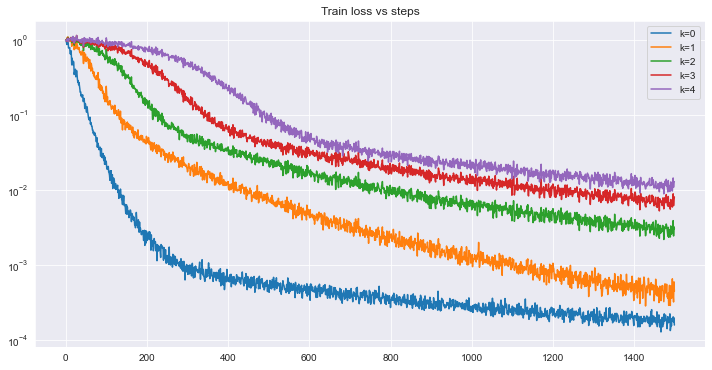

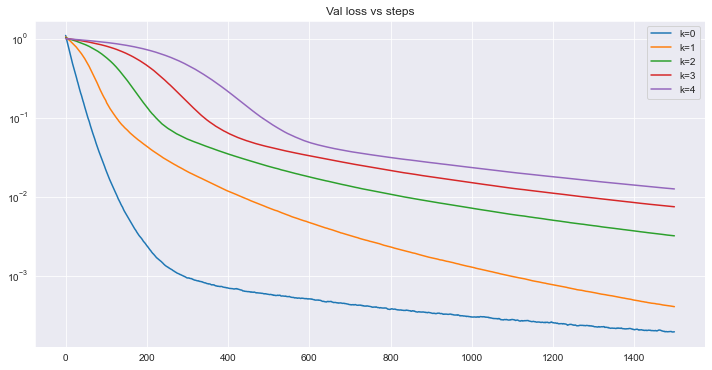

In [37]:
figure = plt.figure(figsize=(12, 6))
for k in range(K):
    plt.plot(np.arange(len(losses[k]['train'])), losses[k]['train'], label='k={:,}'.format(k))
plt.title('Train loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

figure = plt.figure(figsize=(12, 6))
for k in range(K):
    plt.plot(np.arange(len(losses[k]['val'])), losses[k]['val'], label='k={:,}'.format(k))
plt.title('Val loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

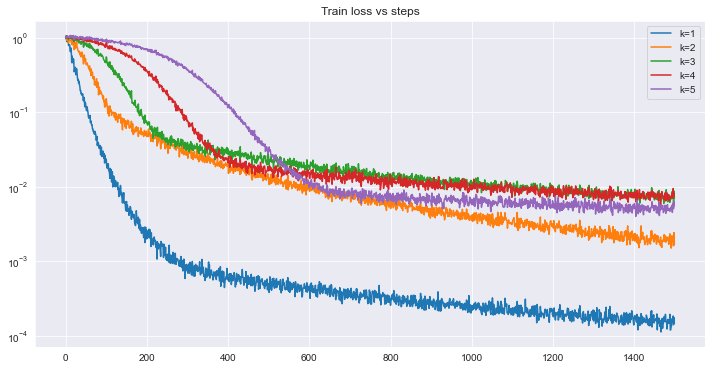

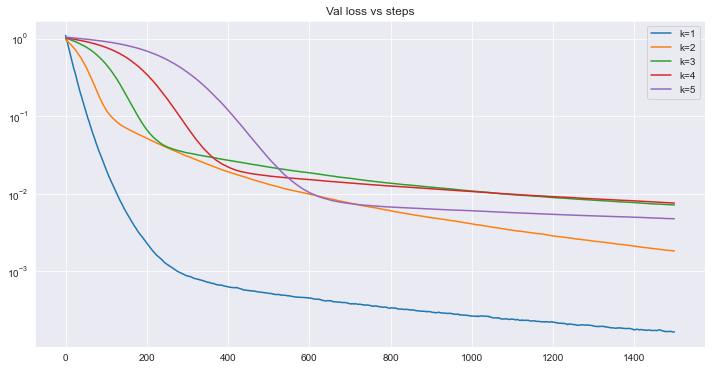

In [74]:
figure = plt.figure(figsize=(12, 6))
for k in range(1, K+1):
    plt.plot(np.arange(len(losses[k]['train'])), losses[k]['train'], label='k={:,}'.format(k))
plt.title('Train loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

figure = plt.figure(figsize=(12, 6))
for k in range(1, K+1):
    plt.plot(np.arange(len(losses[k]['val'])), losses[k]['val'], label='k={:,}'.format(k))
plt.title('Val loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

### 2. Orthogonal staircase

In [72]:
with torch.no_grad():
    norms_val = [torch.norm(X_val[:, k*(k-1)//2: k*(k+1)//2], dim=1, keepdim=True, p=2) for k in range(1, K+1)]
    y_vals = [norms_val[0]]
    for k in range(1, K):
        y_vals.append(y_vals[k-1] + norms_val[k])

    all_norms = [torch.norm(all_Xs[:, k*(k-1)//2: k*(k+1)//2], dim=1, keepdim=True, p=2) for k in range(1, K+1)]
    all_ys_ = [all_norms[0]]
    for k in range(1, K):
        all_ys_.append(all_ys_[k-1] + all_norms[k])

In [73]:
for k in range(1, K+1):
    with torch.no_grad():
        y_val = y_vals[k-1]
        all_ys = all_ys_[k-1]
                               
    print(y_val.shape)
    print(all_ys.shape)
    
    network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
    network.train()
    optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)
    
    train_losses = []
    val_losses = []

    for i in range(n_steps):
        optimizer.zero_grad()
        X = all_Xs[i * batch_size: (i+1) * batch_size, :]
        y = all_ys[i * batch_size: (i+1) * batch_size, :]

        # forward
        y_hat = network.forward(X)
        loss_ = 0.5 * ((y_hat - y) ** 2).mean()

        if i == 0:
            with torch.no_grad():
                loss_0 = loss_.detach().item()
        loss_ = loss_ / loss_0

        # backward and gradient step
        loss_.backward()
        optimizer.step()
        train_losses.append(loss_.detach().item())

        # val
        with torch.no_grad():
            y_hat_val = network.forward(X_val)
            val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean() / loss_0
            val_losses.append(val_loss.detach().item())
            
    losses[k] = {'train': train_losses, 'val': val_losses}

torch.Size([500, 1])
torch.Size([384000, 1])
torch.Size([500, 1])
torch.Size([384000, 1])
torch.Size([500, 1])
torch.Size([384000, 1])
torch.Size([500, 1])
torch.Size([384000, 1])
torch.Size([500, 1])
torch.Size([384000, 1])


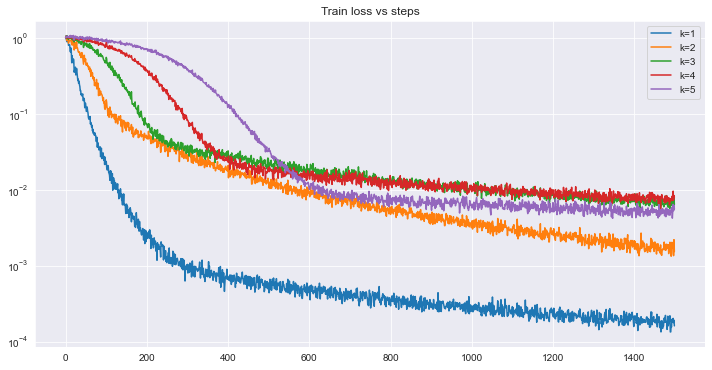

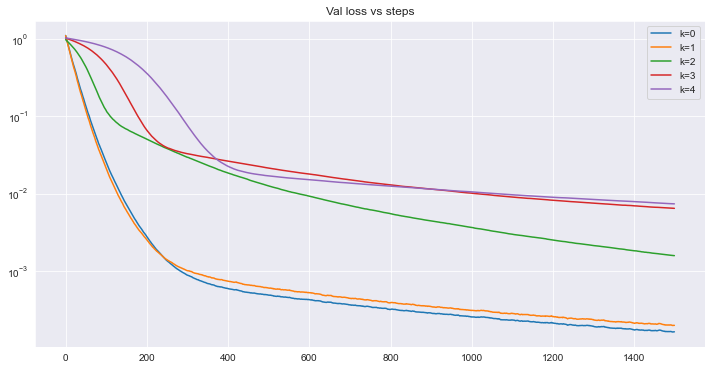

In [71]:
figure = plt.figure(figsize=(12, 6))
for k in range(1, K+1):
    plt.plot(np.arange(len(losses[k]['train'])), losses[k]['train'], label='k={:,}'.format(k))
plt.title('Train loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

figure = plt.figure(figsize=(12, 6))
for k in range(1, K+1):
    plt.plot(np.arange(len(losses[k]['val'])), losses[k]['val'], label='k={:,}'.format(k))
plt.title('Val loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

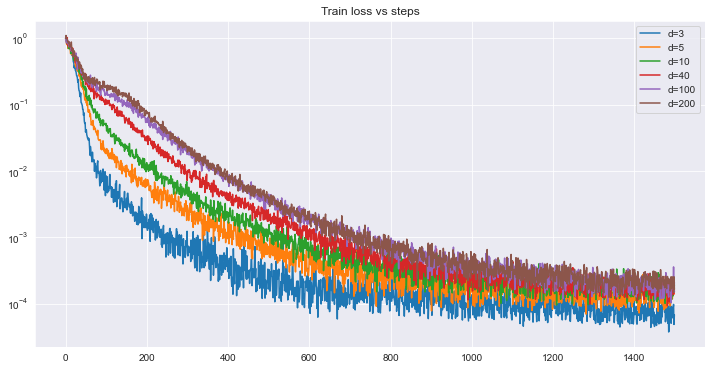

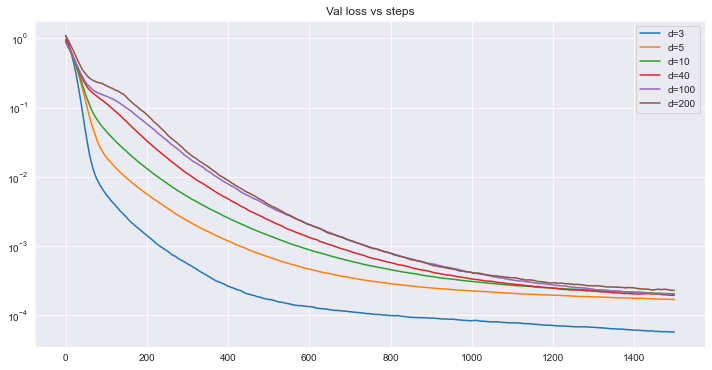

In [38]:
figure = plt.figure(figsize=(12, 6))
for input_dim in ds:
    plt.plot(np.arange(len(losses[input_dim]['train'])), 
             losses[input_dim]['train'], label='d={:,}'.format(input_dim))
plt.title('Train loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

figure = plt.figure(figsize=(12, 6))
for input_dim in ds:
    plt.plot(np.arange(len(losses[input_dim]['val'])), 
             losses[input_dim]['val'], label='d={:,}'.format(input_dim))
plt.title('Val loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

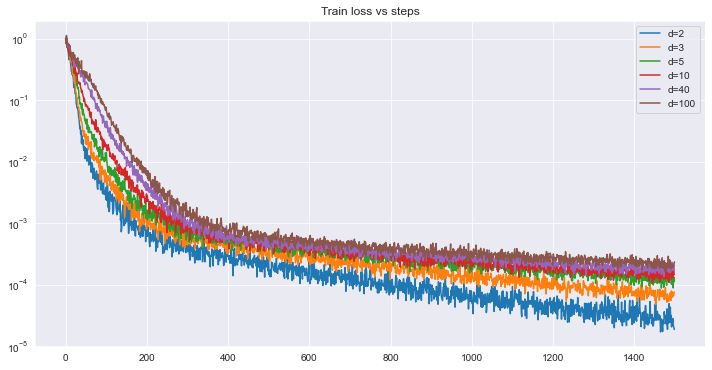

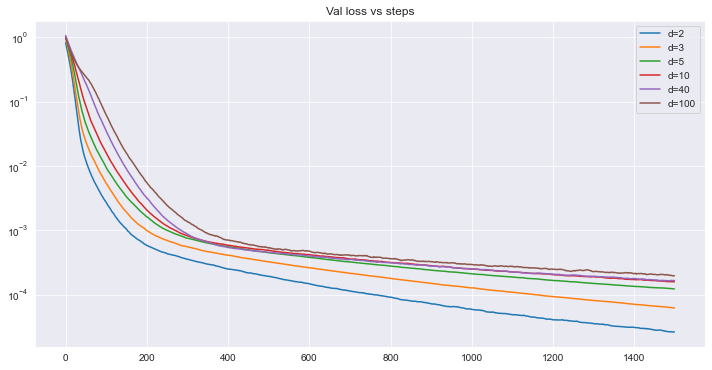

In [35]:
figure = plt.figure(figsize=(12, 6))
for input_dim in ds:
    plt.plot(np.arange(len(losses[input_dim]['train'])), 
             losses[input_dim]['train'], label='d={:,}'.format(input_dim))
plt.title('Train loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

figure = plt.figure(figsize=(12, 6))
for input_dim in ds:
    plt.plot(np.arange(len(losses[input_dim]['val'])), 
             losses[input_dim]['val'], label='d={:,}'.format(input_dim))
plt.title('Val loss vs steps')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network.train()
optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)

In [16]:
train_losses = []
val_losses = []

for i in range(n_steps):
    optimizer.zero_grad()
    X = all_Xs[i * batch_size: (i+1) * batch_size, :]
    y = all_ys[i * batch_size: (i+1) * batch_size, :]

    # forward
    y_hat = network.forward(X)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean()
        
    if i == 0:
        with torch.no_grad():
            loss_0 = loss_.detach().item()
    loss_ = loss_ / loss_0

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean() / loss_0
        val_losses.append(val_loss.detach().item())